# Genetic Optimization (GO) at Emails data 
# (ten departments)

Since it seems that the GO is the best for the task of optimal parameters searching, it was decided to try it on more complex data, such as the emails corpus.

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
# Import external libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 

In [3]:
# initialization
from objfun_node2vec import N2V
n2v = N2V('../data/emails/ten_edges.csv',
            '../data/emails/ten_labels.csv')

In [4]:
default_params=[1., 10, 80, 10]

In [5]:
# performance criteria
def rel(x):
    return len([n for n in x if n < np.inf])/len(x)
def mne(x):
    return np.mean([n for n in x if n < np.inf])
def feo(x):
    return mne(x)/rel(x)

## Experiment run

### Shoot and go

In [6]:
from heur_sg import ShootAndGo
NUM_RUNS = 10
maxeval = 10

In [7]:
def experiment_SG(of, num_runs, hmax, params):
    results = []
    for i in tqdm(range(num_runs), 'Testing hmax = {}'.format(hmax)):
        result = ShootAndGo(of, maxeval=maxeval, hmax=hmax, params=params).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_{}'.format(hmax) # name of the heuristic
        result['hmax'] = hmax
        results.append(result)
    
    # write results to csv file 
    now = datetime.now()
    current_time = now.strftime('%Y%m%d%H%M')
    res = pd.DataFrame(results, columns=['heur', 'run', 'hmax', 'best_x', 'best_y', 'neval'])
    res.to_csv('../results/' + current_time + '_one_eighth_SG_' + str(hmax) + '.csv')
    
    return res

In [8]:
sg_table = pd.DataFrame()
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]: 
    res = experiment_SG(n2v, maxeval, hmax, default_params)
    sg_table = pd.concat([sg_table, res], axis=0)

In [9]:
sg_table.groupby(['hmax'])['best_y'].median()

hmax
0.0     0.743570
1.0     0.742394
2.0     0.742078
5.0     0.741914
10.0    0.738578
20.0    0.738218
50.0    0.737922
inf     0.739401
Name: best_y, dtype: float64

In [10]:
sg_table.groupby(['hmax'])['best_y'].mean()

hmax
0.0     0.743847
1.0     0.743006
2.0     0.739830
5.0     0.741678
10.0    0.740032
20.0    0.737214
50.0    0.738600
inf     0.739028
Name: best_y, dtype: float64

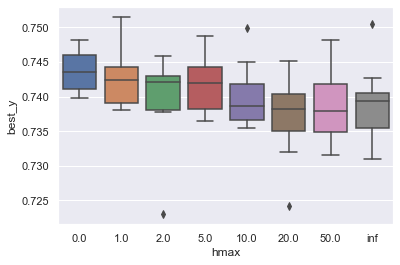

In [11]:
ax = sns.boxplot(x="hmax", y="best_y", data=sg_table)

In [43]:
sg_table.sort_values(by=['best_y'], ascending=False).head(5)

heur  run  hmax                                 best_x    best_y  neval
6    SG_1    6   1.0  [1.7214178926743262, 1.0, 10, 80, 10]  0.751544    inf
2  SG_inf    2   inf  [1.8283190310266115, 1.0, 10, 80, 10]  0.750439    inf
6   SG_10    6  10.0   [3.476639162720879, 1.0, 10, 80, 10]  0.749871    inf
4    SG_1    4   1.0  [1.8492925253591181, 1.0, 10, 80, 10]  0.749847    inf
2    SG_5    2   5.0   [1.778306855029617, 1.0, 10, 80, 10]  0.748814    inf

FEO

In [12]:
results_pivot_sg = sg_table.pivot_table(
    index=['heur', 'hmax'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
results_pivot_sg = results_pivot_sg.reset_index()
results_pivot_sg.sort_values(by='hmax')

C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


heur  hmax  rel
0    SG_0   0.0  0.0
1    SG_1   1.0  0.0
3    SG_2   2.0  0.0
5    SG_5   5.0  0.0
2   SG_10  10.0  0.0
4   SG_20  20.0  0.0
6   SG_50  50.0  0.0
7  SG_inf   inf  0.0

### FSA

In [17]:
from heur_fsa import FastSimulatedAnnealing
from heur_aux import Correction, CauchyMutation

In [18]:
def experiment_fsa(of, maxeval, num_runs, T0, n0, alpha, r, params):
    results = []
    for i in tqdm(range(num_runs), 'Testing T0={}, n0={}, alpha={}, r={}'.format(T0, n0, alpha, r)):
        mut = CauchyMutation(r=r, correction=Correction(of))
        result = FastSimulatedAnnealing(of, maxeval=maxeval, 
                                        T0=T0, n0=n0, alpha=alpha, 
                                        mutation=mut,params=params).search()
        result['run'] = i
        result['heur'] = 'FSA_{}_{}_{}_{}'.format(T0, n0, alpha, r) # name of the heuristic
        result['T0'] = T0
        result['n0'] = n0
        result['alpha'] = alpha
        result['r'] = r
        results.append(result)
    
    return pd.DataFrame(results, columns=['heur', 'run', 'T0', 'n0', 'alpha', 'r', 'best_x', 'best_y', 'neval'])

In [19]:
table_fsa = pd.DataFrame()

for T0 in [1e-10, 1e-2, 1, np.inf]: #[1e-10, 1e-2, 1, np.inf]
    res = experiment_fsa(of=n2v, maxeval=maxeval, num_runs=NUM_RUNS, 
                         T0=T0, n0=1, alpha=2, r=0.5,params=default_params)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [27]:
table_fsa.groupby(['T0'])['best_y'].median()

T0
1.000000e-10    0.729200
1.000000e-02    0.726522
1.000000e+00    0.732221
inf             0.733074
Name: best_y, dtype: float64

In [28]:
table_fsa.groupby(['T0'])['best_y'].mean()

T0
1.000000e-10    0.725616
1.000000e-02    0.720640
1.000000e+00    0.727355
inf             0.725939
Name: best_y, dtype: float64

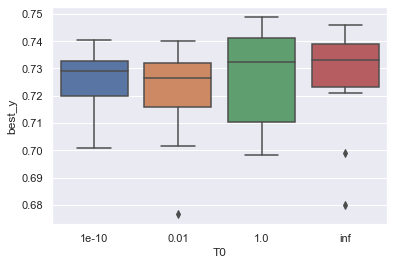

In [29]:
ax = sns.boxplot(x="T0", y="best_y", data=table_fsa)

In [41]:
table_fsa.sort_values(by=['best_y'],ascending=False).head(5)

heur  run            T0  n0  alpha    r  \
4      FSA_1_1_2_0.5    4  1.000000e+00   1      2  0.5   
2      FSA_1_1_2_0.5    2  1.000000e+00   1      2  0.5   
6    FSA_inf_1_2_0.5    6           inf   1      2  0.5   
7      FSA_1_1_2_0.5    7  1.000000e+00   1      2  0.5   
6  FSA_1e-10_1_2_0.5    6  1.000000e-10   1      2  0.5   

                                  best_x    best_y  neval  
4  [3.7526232915805853, 1.0, 10, 80, 10]  0.748968    inf  
2   [2.609063212219957, 1.0, 10, 80, 10]  0.748287    inf  
6  [1.6957189392441014, 1.0, 10, 80, 10]  0.745895    inf  
7  [0.4458664873932152, 1.0, 10, 80, 10]  0.742376    inf  
6  [2.5115891577372116, 1.0, 10, 80, 10]  0.740386    inf

In [20]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0'],
    
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0'])

C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


heur            T0  rel
2  FSA_1e-10_1_2_0.5  1.000000e-10  0.0
0   FSA_0.01_1_2_0.5  1.000000e-02  0.0
1      FSA_1_1_2_0.5  1.000000e+00  0.0
3    FSA_inf_1_2_0.5           inf  0.0

### Genetic algorithm

In [32]:
from heur_go_single import GeneticOptimization

In [33]:
# traditional testing procedure setup
def experiment_go(of, maxeval, num_runs, N):
    results = []
    heur_name = 'GO_{}'.format(N)
    for i in tqdm(range(num_runs), 'Testing {}'.format(heur_name)):
        result = GeneticOptimization(of, maxeval, N=N).search()
        result['run'] = i
        result['heur'] = heur_name
        result['N'] = N
        results.append(result)
    return pd.DataFrame(results, columns=['heur', 'run', 'N', 'best_x', 'best_y', 'neval'])

In [34]:
results_go = pd.DataFrame()
for N in [2,4,8,10]:
    res = experiment_go(of=n2v, maxeval=maxeval, num_runs=NUM_RUNS, N=N)
    results_go = pd.concat([results_go, res], axis=0)


In [35]:
results_go.groupby(['N'])['best_y'].median()

N
2     0.739205
4     0.740462
8     0.740797
10    0.743292
Name: best_y, dtype: float64

In [36]:
results_go.groupby(['N'])['best_y'].mean()

N
2     0.742177
4     0.740273
8     0.741511
10    0.743933
Name: best_y, dtype: float64

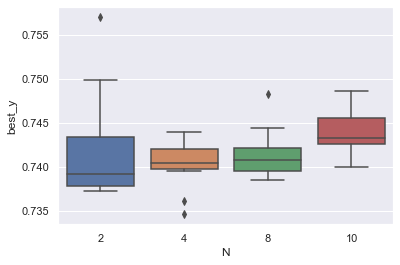

In [37]:
ax = sns.boxplot(x="N", y="best_y", data=results_go)

In [40]:
results_go.sort_values(by=['best_y'],ascending=False).head(5)

heur  run   N                                        best_x    best_y  \
4   GO_2    4   2  [0.35532608837923085, 1.0, 10.0, 80.0, 10.0]  0.757074   
5   GO_2    5   2   [3.4734571153305884, 1.0, 10.0, 80.0, 10.0]  0.749871   
0  GO_10    0  10  [0.30965117343802806, 1.0, 10.0, 80.0, 10.0]  0.748671   
7   GO_8    7   8   [2.8150061415381322, 1.0, 10.0, 80.0, 10.0]  0.748287   
3  GO_10    3  10   [2.3490954852895385, 1.0, 10.0, 80.0, 10.0]  0.746056   

   neval  
4    inf  
5    inf  
0    inf  
7    inf  
3    inf

In [38]:
# performance criteria 
def rel(x):
    return len([n for n in x if n < np.inf])/len(x)
def mne(x):
    return np.mean([n for n in x if n < np.inf])
def feo(x):
    return mne(x)/rel(x)

In [39]:
results_go_pivot = results_go.pivot_table(
    index=['heur', 'N'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
results_go_pivot = results_go_pivot.reset_index()
results_go_pivot.sort_values(by='N')

C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


heur   N  rel
1   GO_2   2  0.0
2   GO_4   4  0.0
3   GO_8   8  0.0
0  GO_10  10  0.0

## Conclusion